In [1]:
import cv2
import skimage

import numpy as np
import matplotlib.pyplot as plt

Morphological operations are crucial for processing binary images as well as extract information from them.

1. Dilation and Erosion
2. Opening and Closing
3. Skeletonization
4. Connected Components
5. Watershed

## 1. Dilation and Erosion

Dilation in image processing is a morphological operation that expands the boundaries of objects in a binary image by adding pixels to the object's edges, making the objects thicker and larger. Erosion, on the other hand, shrinks the boundaries of objects by removing pixels from the object's edges, resulting in thinner and smaller objects in the binary image.

In `OpenCV`, we have `cv2.dilate()` and `cv2.erode()` to perform these operations.

Both methods use the same parameters: 

`cv2.erode(src, kernel, iterations)`

`cv2.dilate(src, kernel, iterations)`

- src: the image we would like to erode/dilate
- kernel: is the kernel to be used for the operation
- iterations: number of times the operation is applied

check the documentation for other parameters.

These methods return the eroded/dilated images. Let's create a circle and apply these operations to see what happens:

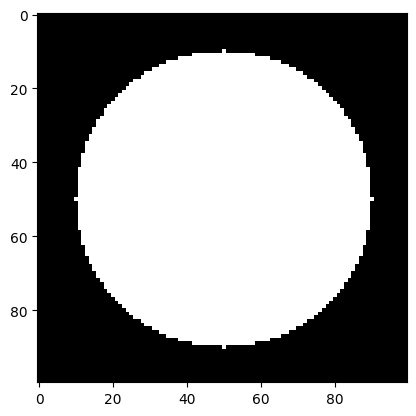

In [2]:
# Creating a circle
im_size = 100
x = int(im_size/2)
y = int(im_size/2)
r = 40

im_circle = np.zeros((im_size, im_size), dtype="uint8")
im_circle = cv2.circle(im_circle, (x, y), r, 255, -1)

plt.imshow(im_circle, cmap='gray')

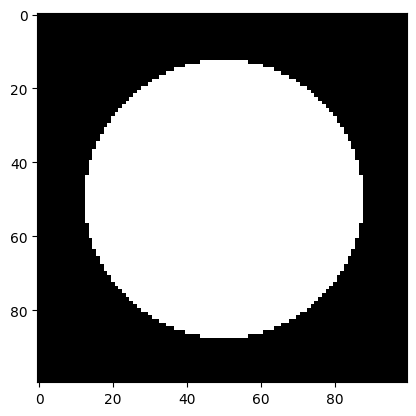

In [3]:
# Erosion
kernel = np.ones((5, 5), dtype="uint8")
im_erosion = cv2.erode(im_circle, kernel, iterations=1)
plt.imshow(im_erosion, cmap='gray')

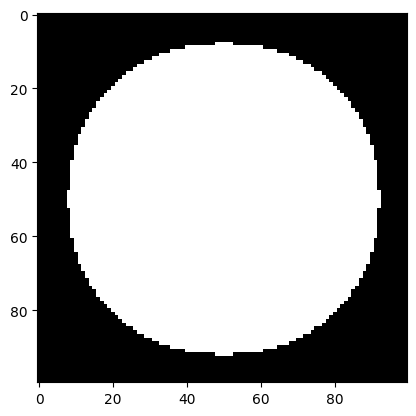

In [4]:
# Dilation
kernel = np.ones((5, 5), dtype="uint8")
im_dilation = cv2.dilate(im_circle, kernel, iterations=1)
plt.imshow(im_dilation, cmap='gray')

You might have noticed that indeed erosion made the circle smaller and dilation made the circle larger. Let's stack all three to see the effect more clearly:

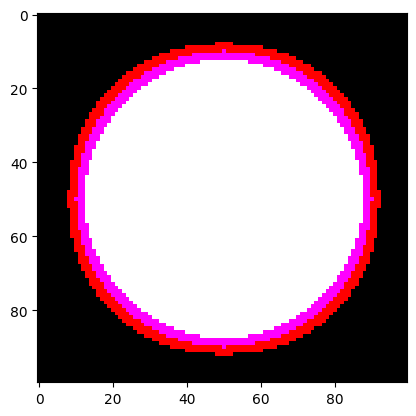

In [5]:
stacked = np.stack((im_dilation, im_erosion, im_circle), axis=2)
plt.imshow(stacked)

The border between the red and magenta regions is the perimeter of the original circle. Red region represents the area added to the circle after the dilation operation. Magenta region represents the area eroded area after the erosion. The difference between dilation and erosion is called the morphological gradient (magenta + red). So far, so good.

Now let's see what happens if we change the kernel size:

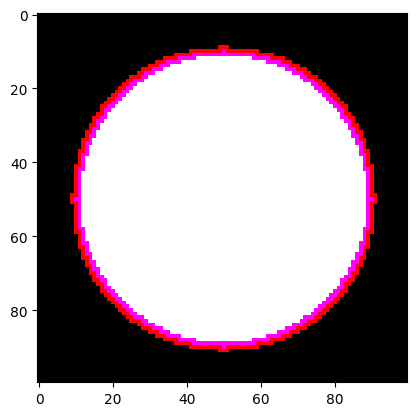

In [6]:
# Smaller kernel
kernel = np.ones((3, 3), dtype="uint8") # (3, 3) instead of (5, 5)
im_erosion = cv2.erode(im_circle, kernel, iterations=1)
im_dilation = cv2.dilate(im_circle, kernel, iterations=1)
stacked = np.stack((im_dilation, im_erosion, im_circle), axis=2)
plt.imshow(stacked)

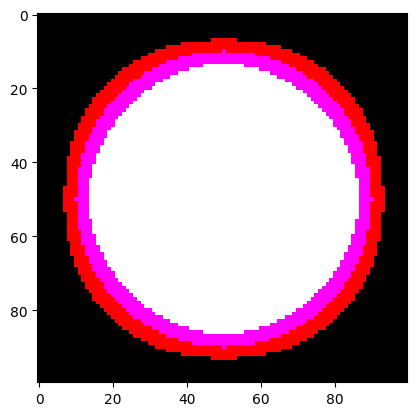

In [7]:
# Larger kernel
kernel = np.ones((7, 7), dtype="uint8") # (7, 7) instead of (5, 5)
im_erosion = cv2.erode(im_circle, kernel, iterations=1)
im_dilation = cv2.dilate(im_circle, kernel, iterations=1)
stacked = np.stack((im_dilation, im_erosion, im_circle), axis=2)
plt.imshow(stacked)

Smaller kernel resulted in less dilation/erosion and larger kernel resulted in more dilation/erosion. What about the iterations? If we set the iterations to 2, this means we repeat the operation twice, which should result in more dilation and erosion:

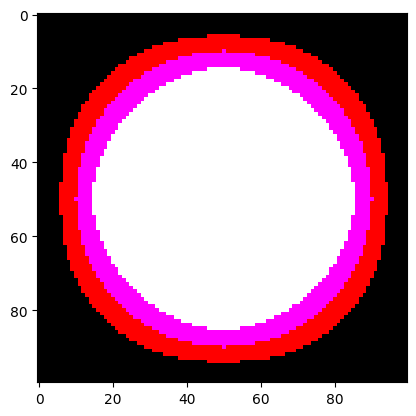

In [8]:
kernel = np.ones((5, 5), dtype="uint8")
im_erosion = cv2.erode(im_circle, kernel, iterations=2) # iterations 2 instead of 1
im_dilation = cv2.dilate(im_circle, kernel, iterations=2) # iterations 2 instead of 1
stacked = np.stack((im_dilation, im_erosion, im_circle), axis=2)
plt.imshow(stacked)

Indeed, more iterations more erosion/dilation. Now, I know what you are thinking "What if we combine these operations?", let me answer that next.

**Exercise 3.1**

Apply erosion and dilation to the blobs images.

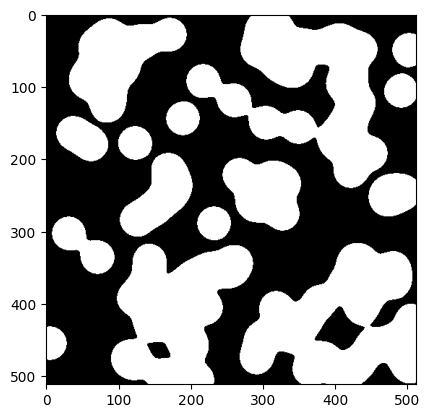

In [21]:
im_blobs = skimage.data.binary_blobs()
plt.imshow(im_blobs, cmap='gray')

In [24]:
im_blobs = im_blobs * 255

In [22]:
im_blobs = im_blobs.astype('uint8')

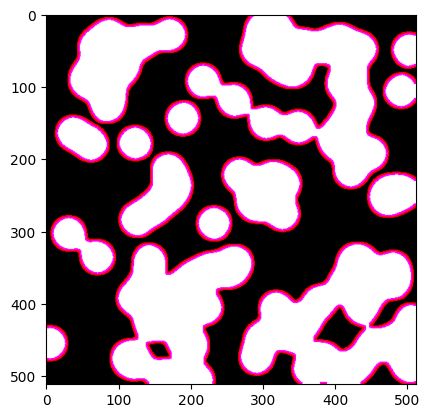

In [25]:
# YOUR CODE HERE
im_blobs_ero = cv2.erode(im_blobs, kernel, iterations=1)
im_blobs_dil = cv2.dilate(im_blobs, kernel, iterations=1)
stacked = np.stack((im_blobs_dil, im_blobs_ero, im_blobs), axis=2)
plt.imshow(stacked)

## 2. Opening and Closing

Dilation and erosion act in opposite directions. But they are not invertible, i.e. when you apply erosion followed by dilation to an image, there is no guarentee that you obtain the same image. Same for dilation followed by erosion. Let's see what happens when we combine these operations.

In [26]:
# Dilation + Erosion
kernel = np.ones((5, 5), dtype="uint8")
im_d = cv2.dilate(im_circle, kernel, iterations=1)
im_de = cv2.erode(im_d, kernel, iterations=1)

let's compare the resulting image (`im_de`) and the original image (`im_circle`) pixel by pixel

In [27]:
np.all(im_de == im_circle)

True

We got the original image when we applied Dilation + Erosion. Let's check Erosion + Dilation:

In [28]:
# Erosion + Dilation
kernel = np.ones((5, 5), dtype="uint8")
im_e = cv2.erode(im_circle, kernel, iterations=1)
im_ed = cv2.dilate(im_e, kernel, iterations=1)

In [29]:
np.all(im_ed == im_circle)

False

In [30]:
print(f'There are {np.sum(im_ed != im_circle)} pixels that are different')

There are 4 pixels that are different


This time we didn't get the same image. It is still close but not exactly the same. 4 pixels are different, let's visualize them, look at the blue pixels:

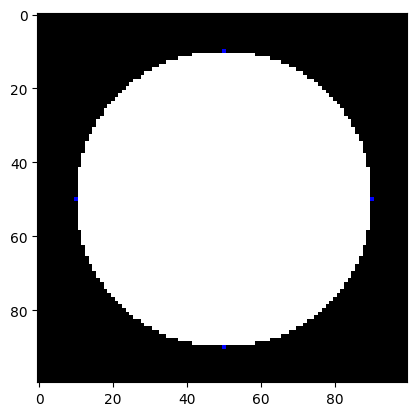

In [31]:
stacked = np.stack((im_ed, im_ed, im_circle), axis=2)
plt.imshow(stacked)

But what is the point of all this? Yes we can chain the operations, so what? These operations are very useful as we will demonstrate below. In fact, they have their own names:

- Opening: Erosion + Dilation
- Closing: Dilation + Erosion

Opening removes small objects/noise, or protrusions on the objects. Closing can be used to remove small intrusions and holes on the object. It can also be used to connect objects that are nearly touching.

In fact when we applied opening above we eliminated the protrusions (the blue pixels). Let's look at a few examples.

Say, we have an image of a rod. We used a neural network to find the pixels that belong to the rod. Our NN is good enough but not perfect. We obtained the following segmentation mask:

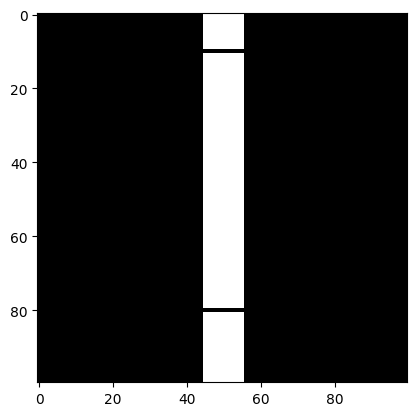

In [32]:
im_size = 100
im_rod = np.zeros((im_size, im_size), dtype="uint8")
im_rod[:, 45:56] = 255
im_rod[10, 45:56] = 0
im_rod[80, 45:56] = 0
plt.imshow(im_rod, cmap='gray')

We know that there is a single rod in the image but in the segmentation mask we see a discontinuity. Let's apply opening and closing to see what happens.

In [33]:
def opening_closing_plot(im_rod, kernel = np.ones((5, 5), dtype="uint8")):
    # Opening
    im_rod_e = cv2.erode(im_rod, kernel, iterations=1)
    im_rod_opening = cv2.dilate(im_rod_e, kernel, iterations=1)

    # Closing
    im_rod_d = cv2.dilate(im_rod, kernel, iterations=1)
    im_rod_closing = cv2.erode(im_rod_d, kernel, iterations=1)

    fig, axes = plt.subplots(1, 3, figsize=(12, 4)) 

    axes[0].imshow(im_rod, cmap='gray')
    axes[0].set_title('Original Image')

    axes[1].imshow(im_rod_opening, cmap='gray')
    axes[1].set_title('Opening')

    axes[2].imshow(im_rod_closing, cmap='gray')
    axes[2].set_title('Closing')

    plt.tight_layout()

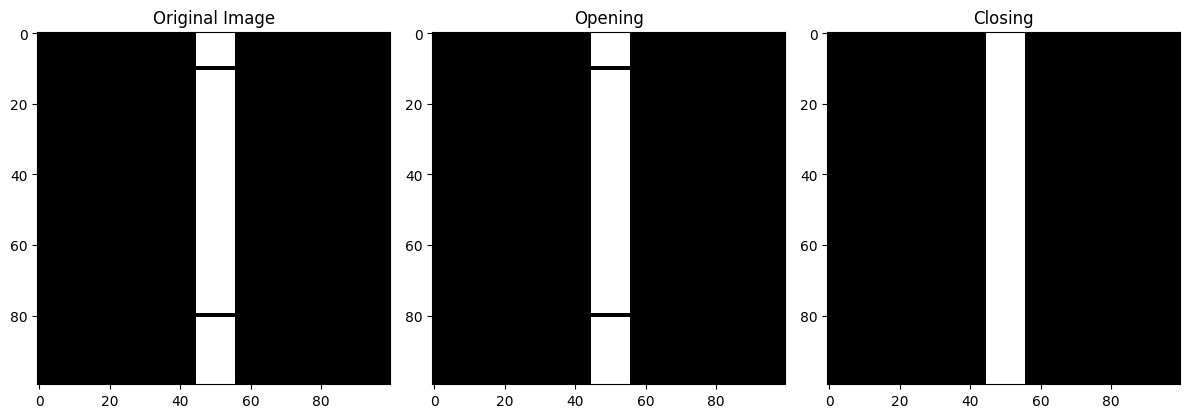

In [34]:
opening_closing_plot(im_rod)

Indeed closing can connect objects that are nearly touching. Opening did nothing in this case. What about intrusions and holes?

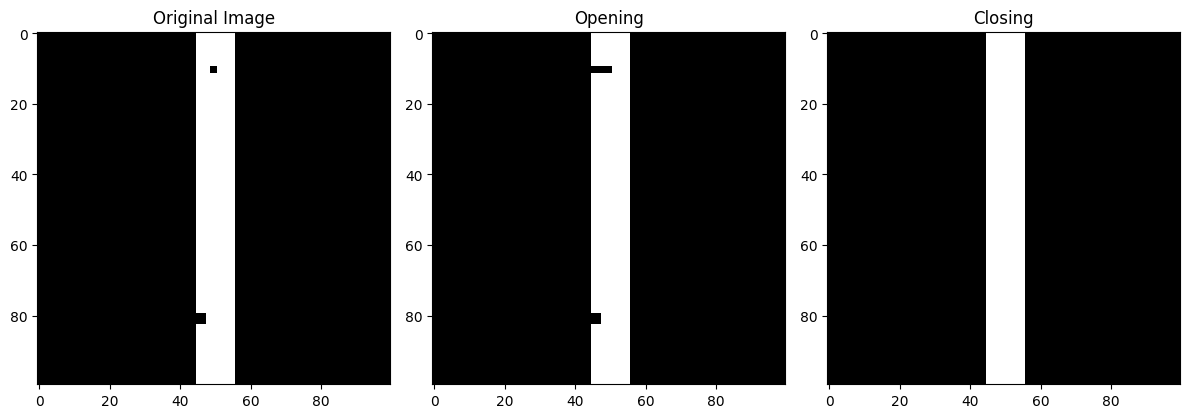

In [35]:
# Create new image with a hole and a notch
im_size = 100
im_rod = np.zeros((im_size, im_size), dtype="uint8")
im_rod[:, 45:56] = 255
im_rod[10:12, 49:51] = 0 # hole
im_rod[80:83, 45:48] = 0 # notch

opening_closing_plot(im_rod)

Closing closes 😬😬 What if we have a few pixels detected as the rod but actually not the rod + a protrusion?

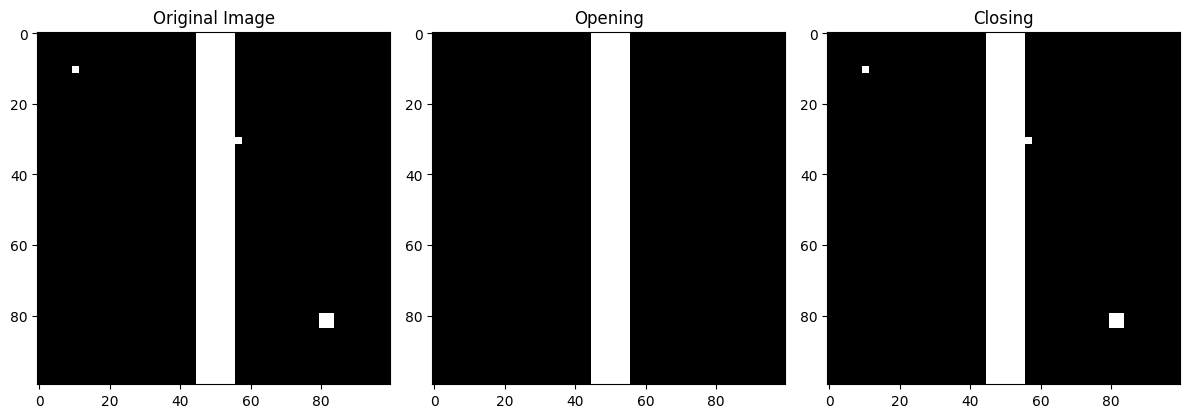

In [36]:
# Create new image with protrusion and noise
im_size = 100
im_rod = np.zeros((im_size, im_size), dtype="uint8")
im_rod[:, 45:56] = 255
im_rod[10:12, 10:12] = 255 # noise
im_rod[80:84, 80:84] = 255 # noise
im_rod[30:32, 56:58] = 255 # protrusion

opening_closing_plot(im_rod)

this time closing didn't help but opening did. Now you know dilation, erosion and their combination. It is important to understand what they do so that you can use them effectively in different situations you will encounter. You can even combine opening and closing.

**Exercise 3.2**

Apply erosion, dilation, opening, closing to `im_blobs` in order to:

- remove white pixels in the background (salt)
- remove black pixels on the blobs (pepper)
- connecting blobs
- disconnecting blobs

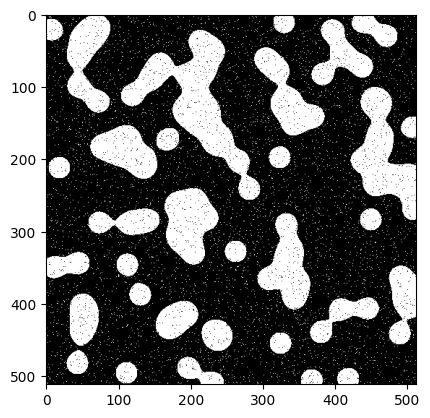

In [37]:
im_blobs = skimage.data.binary_blobs(volume_fraction=0.3) # creating binary blobs image
im_blobs = skimage.util.random_noise(im_blobs, mode='s&p') # adding salt and pepper noise
plt.imshow(im_blobs, cmap='gray')

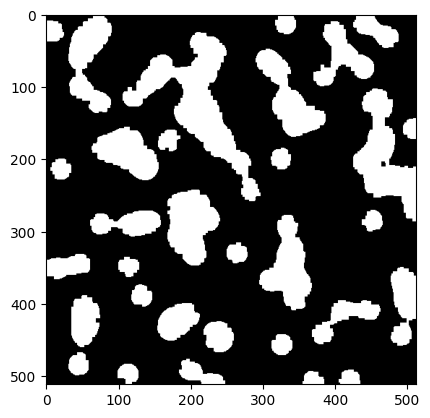

In [41]:
# YOUR CODE HERE
kernel = np.ones((3, 3), dtype="uint8")
im_blobs = cv2.erode(im_blobs, kernel, iterations=1)
im_blobs = cv2.dilate(im_blobs, kernel, iterations=1)

im_blobs = cv2.dilate(im_blobs, kernel, iterations=1)
im_blobs = cv2.erode(im_blobs, kernel, iterations=1)
plt.imshow(im_blobs, cmap='gray')

## 3. Skeletonization 💀

Obtaining the skeleton of an image is called skeletonization. What is a skeleton? You might guess what it is by its name, it is best understood by looking at an example. We will use `scikit-image`. Let's use another sample image from `scikit-image`:

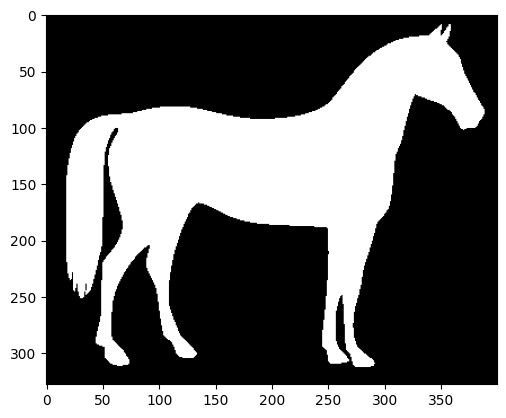

In [42]:
im_horse = skimage.data.horse()
im_horse = 1 - im_horse # invert
plt.imshow(im_horse, cmap='gray')

and apply skeletonization to it:

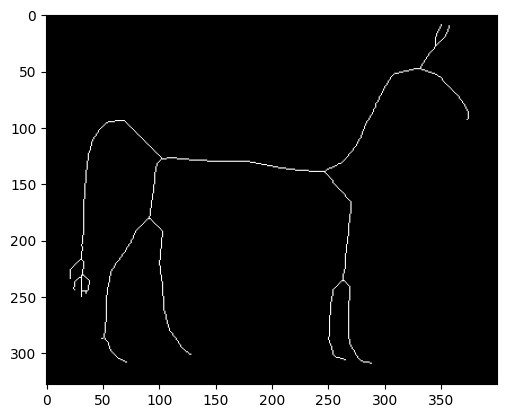

In [43]:
from skimage.morphology import skeletonize
skeleton = skeletonize(im_horse)
plt.imshow(skeleton, cmap='gray')

An image skeleton, also known as a medial axis or topological skeleton, is a representation of an object within an image that captures its essential shape and connectivity. It is a one-pixel-wide representation that highlights the central and critical features of the object while simplifying its complex boundary, making it useful for tasks like shape analysis, object recognition, and pattern matching in image processing. We will come back to skeletons in week 4 to learn how we can use it for object measurement.

**Exercise 3.3**

Apply skeletonization to `blobs`.

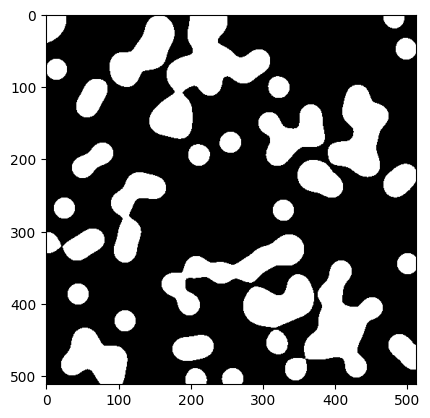

In [44]:
im_blobs = skimage.data.binary_blobs(volume_fraction=0.3) # creating binary blobs image
plt.imshow(im_blobs, cmap='gray')

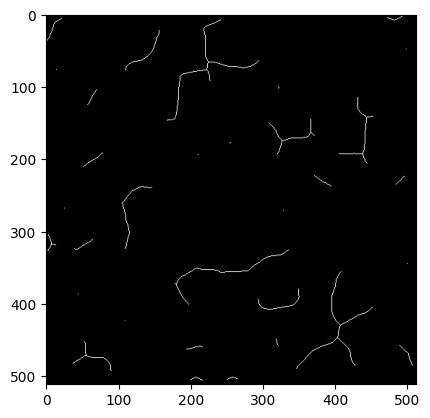

In [45]:
# YOUR CODE HERE
im_skeleton = skeletonize(im_blobs)
plt.imshow(im_skeleton, cmap='gray')

## 4. Connected Components

Imagine we have a binary image with two circles:

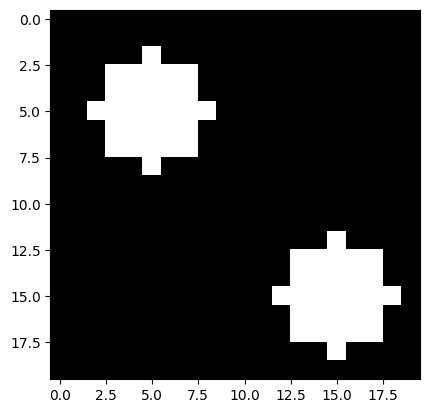

In [46]:
im_circles = np.zeros((20, 20), dtype="uint8")
im_circles = cv2.circle(im_circles, (5, 5), 3, 255, -1)
im_circles = cv2.circle(im_circles, (15, 15), 3, 255, -1)

plt.imshow(im_circles, cmap='gray')

Yes I know these are not circles but bear with me, seeing individual pixels is helpful for understanding what is going on.

We know that pixels with a value of 0 belong to the background and pixels with a value of 255 belong to the circles. But which white pixels belong to which instance of circle? In a sense, we are looking for pixels that are neighbors to each other i.e. _connected_.

We can use [connected components](https://en.wikipedia.org/wiki/Component_(graph_theory)) from graph theory to find which pixels are "connected" and from there infer which pixels belong to the same object. We can do this in one line with `OpenCV`.

In [47]:
retval, labels = cv2.connectedComponents(im_circles)

`retval` is the number of components detected.

In [48]:
retval

3

So there are 3 components but we have 2 objects, how come? Background is also a connected component.

Then, what is `labels`? This is a NumPy array of the same shape as the input binary image. It assigns a unique integer label to each pixel in the input image, indicating the connected component to which the pixel belongs. Pixels with the same label belong to the same connected component.

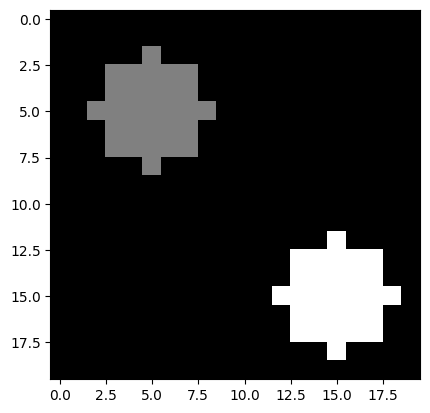

In [49]:
plt.imshow(labels, cmap='gray')

Indeed we see that different objects have different shades! Let's plot label values to make this even more clear:

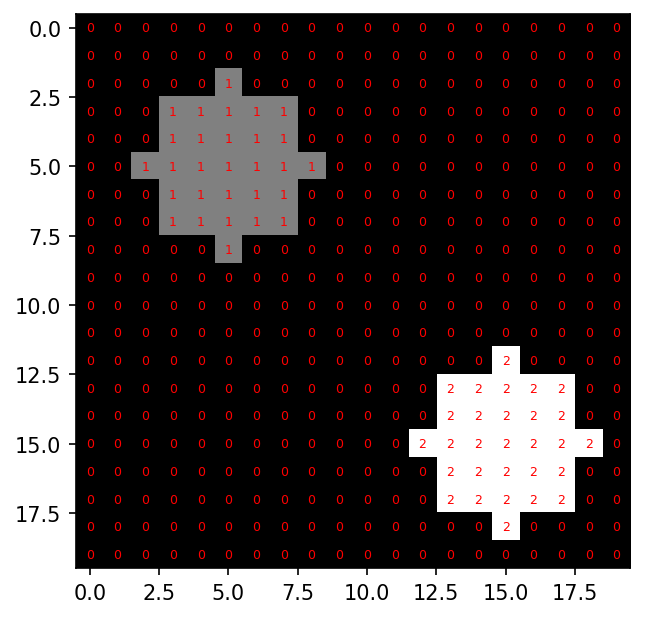

In [50]:
fig, ax = plt.subplots(dpi=150)
ax.imshow(labels, cmap='gray')

for i in range(labels.shape[0]):
    for j in range(labels.shape[1]):
        ax.text(j, i, str(labels[i, j]), color='r', ha='center', va='center', size=6)

The background is assigned the label `0` and other connected components or objects are labeled with subsequent integers. In our case `1` and `2`. This is a common labeling convention in image segmentation and analysis.

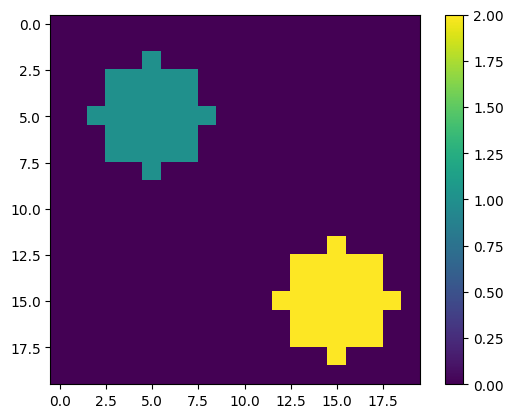

In [51]:
# For visualization use any color map that works best for your case
plt.imshow(labels, cmap='viridis')
plt.colorbar()

**Exercise 3.4**

Find and visualize the connected components in `im_blobs`.

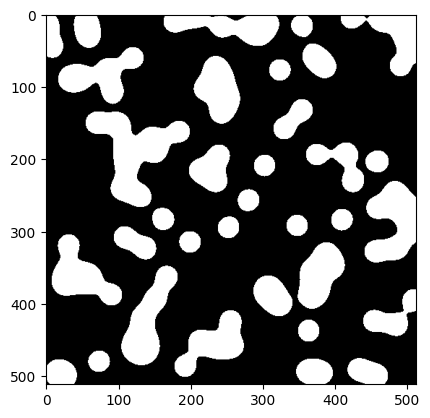

In [52]:
im_blobs = skimage.data.binary_blobs(volume_fraction=0.3)
plt.imshow(im_blobs, cmap='gray')

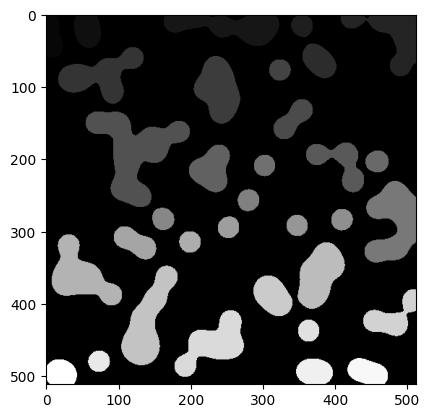

In [55]:
# YOUR CODE HERE
im_blobs = im_blobs.astype('uint8')
retval, labels = cv2.connectedComponents(im_blobs)
plt.imshow(labels, cmap='gray')

Cool so now you know connected components! But we skipped explaining a core concept. What is a neighbor? What does it mean to be connected?

Consider the following simple 5x5 px image with a 3x3 px rectangle at the center:

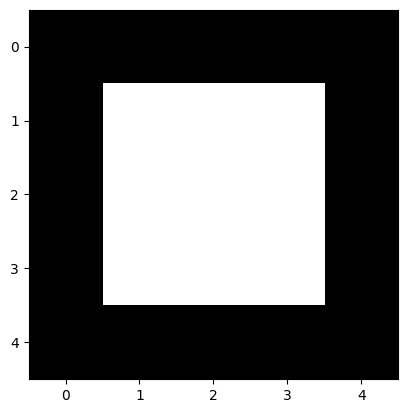

In [56]:
small_image = np.zeros((5, 5), dtype='uint8')
small_image[1:4, 1:4] = 255
plt.imshow(small_image, cmap='gray')

Which pixels are the neighbors of the pixel at (2, 2)? Let's draw this better by showing each pixel using gridlines and draw connections between the pixels:

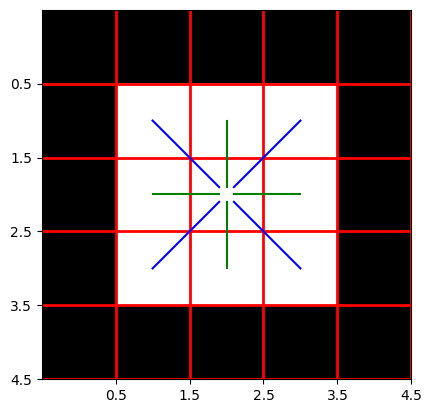

In [57]:
small_image = np.zeros((5, 5), dtype='uint8')
small_image[1:4, 1:4] = 255
plt.imshow(small_image, cmap='gray')
plt.xticks(np.arange(0.5, 5, 1), labels=['0.5', '1.5', '2.5', '3.5', '4.5'])
plt.yticks(np.arange(0.5, 5, 1), labels=['0.5', '1.5', '2.5', '3.5', '4.5'])
plt.grid(True, color='red', linewidth=2)
plt.plot([2.1, 3], [2, 2], color='green')
plt.plot([1, 1.9], [2, 2], color='green')
plt.plot([2, 2], [1, 1.9], color='green')
plt.plot([2, 2], [2.1, 3], color='green')
plt.plot([2.1, 3], [2.1, 3], color='blue')
plt.plot([1, 1.9], [3, 2.1], color='blue')
plt.plot([1, 1.9], [1, 1.9], color='blue')
plt.plot([2.1, 3], [1.9, 1], color='blue')


Green lines connect the 4 pixels that share an edge with the center pixel, blue lines connect the 4 pixels that share a corner with the center pixel. If we consider only edge connectivity center pixel has 4 neighbors. If we consider edge and corner connectivity, the center pixel has 8 neighbors. What about a black and a white pixel with edge connectivity? Are they connected? Nope. Only neighbors of same intensity are connected.

Which connectivity does `OpenCV` use, 4 or 8? By default it uses 8. But we can change it. Let's see it on another image:

Text(0.5, 1.0, 'connectivity=4')

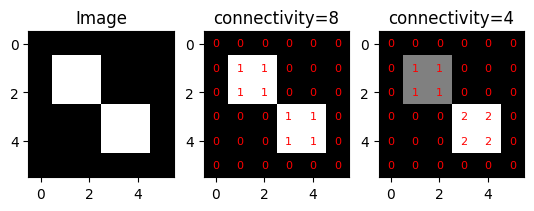

In [58]:
fig, ax = plt.subplots(1, 3)

# Create image
small_image = np.zeros((6, 6), dtype='uint8')
small_image[1:3, 1:3] = 255
small_image[3:5, 3:5] = 255
# Display image
ax[0].imshow(small_image, cmap='gray')
ax[0].set_title('Image')

# Connectivity 8 (Default)
retval, labels = cv2.connectedComponents(small_image, connectivity=8) # default

ax[1].imshow(labels, cmap='gray')

for i in range(labels.shape[0]):
    for j in range(labels.shape[1]):
        ax[1].text(j, i, str(labels[i, j]), color='r', ha='center', va='center', size=8)
ax[1].set_title('connectivity=8')

# Connectivity 4
retval, labels = cv2.connectedComponents(small_image, connectivity=4)

ax[2].imshow(labels, cmap='gray')

for i in range(labels.shape[0]):
    for j in range(labels.shape[1]):
        ax[2].text(j, i, str(labels[i, j]), color='r', ha='center', va='center', size=8)
ax[2].set_title('connectivity=4')


Now we can use the `labels` to find object area (in terms of number of pixels), object center, and a bounding box for the object. Luckily, `OpenCV` does that for us:

`retval, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_image)`

you know the first two, the next two gives us more information on the connected components:

- retval: The total number of connected components found in the input binary image.

- labels: This is a NumPy array of the same shape as the input binary image. It assigns a unique integer label to each pixel in the input image, indicating the connected component to which the pixel belongs. Pixels with the same label belong to the same connected component.

- stats: This is a NumPy array of shape (N, 5), where N is the number of connected components found. Each row of the stats array corresponds to a connected component and contains the following statistics:
    - stats[i, 0]: Leftmost (x) coordinate of the bounding box of the i-th connected component.
    - stats[i, 1]: Topmost (y) coordinate of the bounding box of the i-th connected component.
    - stats[i, 2]: Width of the bounding box of the i-th connected component.
    - stats[i, 3]: Height of the bounding box of the i-th connected component.
    - stats[i, 4]: Total number of pixels in the i-th connected component.
    

- centroids: This is a NumPy array of shape (N, 2), where N is the number of connected components found. Each row of the centroids array corresponds to a connected component and contains the (x, y) coordinates of the centroid of that component.

Let's run `cv2.connectedComponentsWithStats()` on proper circles:

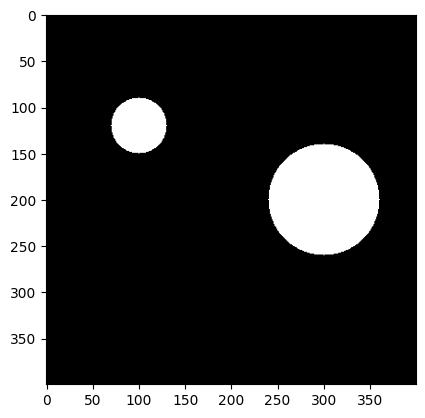

In [59]:
im_circles = np.zeros((400, 400), dtype="uint8")
im_circles = cv2.circle(im_circles, (100, 120), 30, 255, -1)
im_circles = cv2.circle(im_circles, (300, 200), 60, 255, -1)

plt.imshow(im_circles, cmap='gray')

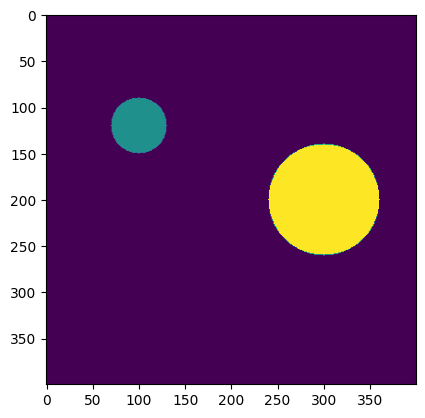

In [60]:
retval, labels, stats, centroids = cv2.connectedComponentsWithStats(im_circles)
plt.imshow(labels)

In [61]:
# x, y, w, h, area
stats

array([[     0,      0,    400,    400, 145890],
       [    70,     90,     61,     61,   2821],
       [   240,    140,    121,    121,  11289]], dtype=int32)

Each row is a connect component. Row index corresponds to the label in `labels`. We can use (x, y, w, h) to draw bounding boxes:

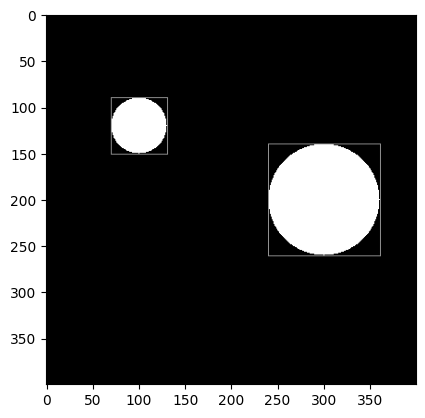

In [62]:
for i in range(1, len(stats)):
    x, y, w, h, _ = stats[i]
    im_circles = cv2.rectangle(im_circles, (x, y), (x+w, y+h), 150, 1)
plt.imshow(im_circles, cmap='gray')

area column can be used to filter components by size. `centroids` contain the centers:

In [64]:
centroids

array([[193.64726849, 200.99856056],
       [100.        , 120.        ],
       [300.        , 200.        ]])

**Exercise 3.5**

Detect the blobs in the image below. You will see that sometimes two blobs are connected by a very thin connection. It is up to you to consider them as separate objects or not.

- How many blobs are there?
- What is the average blob size?
- Draw bounding boxes around the blobs

Note that blob generation is random, which means if you repeat blob image generation, you will get a new image. This is useful for testing your solution on different images. So test the robustness of your solution on different blobs images.

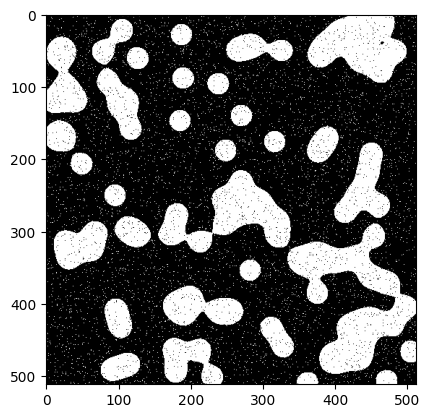

In [87]:
blobs = skimage.data.binary_blobs(volume_fraction=0.3) # creating binary blobs image
blobs = skimage.util.random_noise(blobs, mode='s&p') # adding noise
plt.imshow(blobs, cmap='gray')

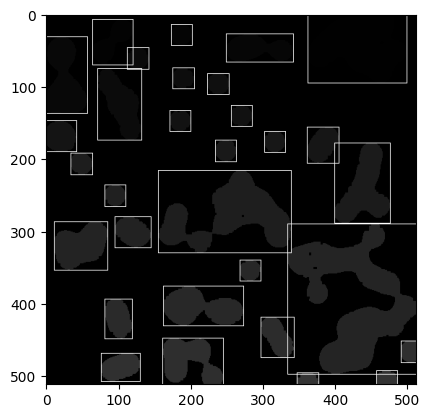

In [88]:
# YOUR CODE HERE
blobs = blobs.astype('uint8')
kernel = np.ones((3, 3), dtype="uint8")

blobs = cv2.erode(blobs, kernel, iterations=1)
blobs = cv2.dilate(blobs, kernel, iterations=1)

blobs = cv2.dilate(blobs, kernel, iterations=1)
blobs = cv2.erode(blobs, kernel, iterations=1)

retval, labels, stats, centroids = cv2.connectedComponentsWithStats(blobs)

for i in range(1, len(stats)):
    x,y,w,h,_ = stats[i]
    im_rec = cv2.rectangle(labels, (x, y), (x+w, y+h), 150, 1)
plt.imshow(im_rec, cmap='gray')
    

## 5. Watershed

What if the two objects are overlapping? If we apply connected components, they will have the same label because they are connected.

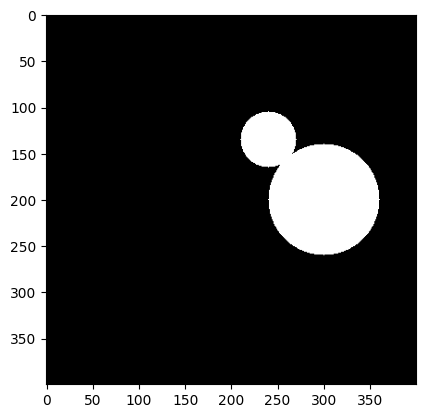

In [89]:
# Create two overlapping circles
im_circles = np.zeros((400, 400), dtype="uint8")
im_circles = cv2.circle(im_circles, (240, 135), 30, 255, -1)
im_circles = cv2.circle(im_circles, (300, 200), 60, 255, -1)

plt.imshow(im_circles, cmap='gray')

Watershed algorithm is widely used to separate overlapping objects. It is used to find a boundary between overlapping objects. The way it works require a sure background (sure_bg), sure foreground (sure_fg) and an unknown region in between the two.

**Sure_bg**: If you apply the `dilate` method to `im_circles` you will have a foreground wider than it is supposed to be. This means remaining background is for sure the background.

**Sure_fg**: If you apply the `erode` method to `im_circles` you will have a foreground smaller than it is supposed to be and without overlapping. So you are sure this is the foreground.

**Unknown region**: And finally `sure_bg - sure_fg` will result in the unknown region.

(-0.5, 399.5, 399.5, -0.5)

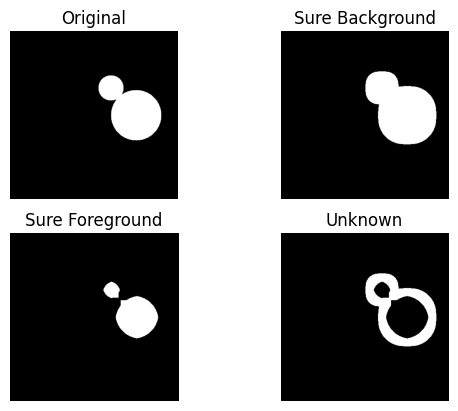

In [90]:
kernel = np.ones((7, 7), dtype="uint8")
sure_bg = cv2.dilate(im_circles, kernel, iterations=3)
sure_fg = cv2.erode(im_circles, kernel, iterations=3) # make sure erosion separates the two
unknown = sure_bg - sure_fg

fig, ax = plt.subplots(2, 2)

ax[0, 0].imshow(im_circles, cmap='gray')
ax[0, 0].set_title('Original')
ax[0, 0].axis('off')
ax[0, 1].imshow(sure_bg, cmap='gray')
ax[0, 1].set_title('Sure Background')
ax[0, 1].axis('off')
ax[1, 0].imshow(sure_fg, cmap='gray')
ax[1, 0].set_title('Sure Foreground')
ax[1, 0].axis('off')
ax[1, 1].imshow(unknown, cmap='gray')
ax[1, 1].set_title('Unknown')
ax[1, 1].axis('off')

Now what we need to do is to create `labels` such that the unknown region has a label `0`, the background `1` and the sure foregrounds `2` and `3`. Here are the steps do achieve that:

1. Apply connected components to `sure_fg`. We will have background `0` and objects `1` and `2`.
2. Add `1` to all labels in order to set background to `1` (instead of `0`).
3. Update `labels` such that the unknown region is labeled as `0`.
4. Apply `cv2.watershed()`.

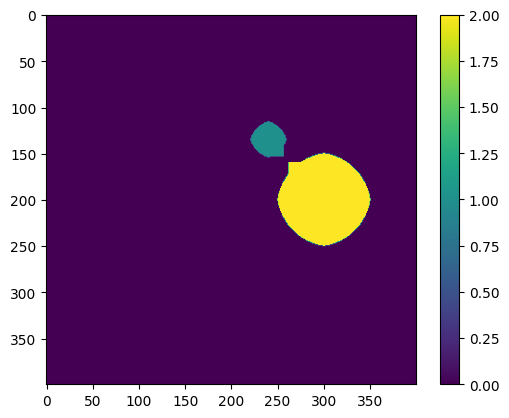

In [91]:
# Step 1
retval, labels, stats, centroids = cv2.connectedComponentsWithStats(sure_fg)
plt.imshow(labels)
plt.colorbar()

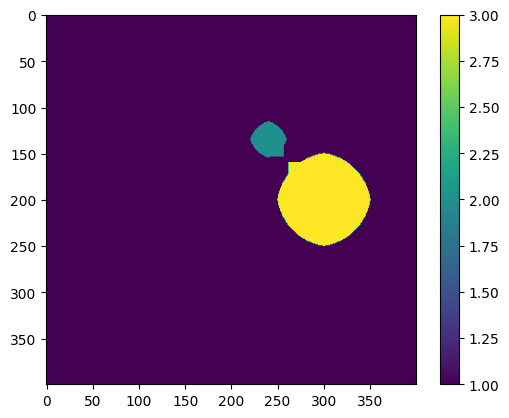

In [92]:
# Step 2
# Check the colobar
labels = labels + 1
plt.imshow(labels)
plt.colorbar()

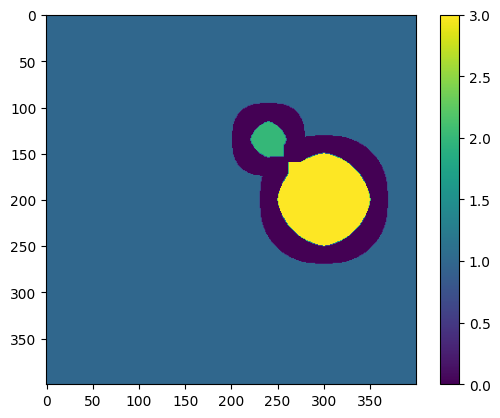

In [93]:
# Step 3
labels[unknown == 255] = 0
plt.imshow(labels)
plt.colorbar()

In [94]:
# OpenCV wants a 3-channel image for watershed
im_circles = np.stack((im_circles, im_circles, im_circles), axis=2)
im_circles.shape

(400, 400, 3)

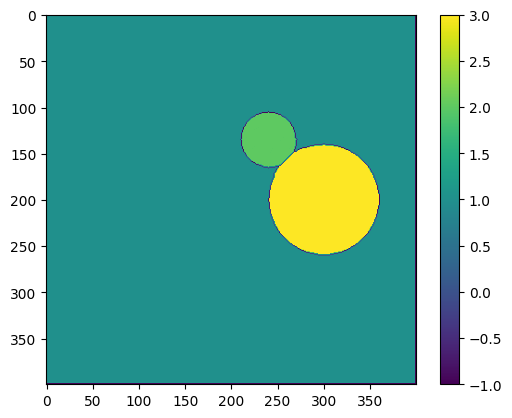

In [95]:
# Step 4
labels = cv2.watershed(im_circles, labels)
plt.imshow(labels)
plt.colorbar()

It worked 🥳 We have different labels for overlapping objects 🥳 🥳  But what is `-1` in the colorbar? It is the border between the objects. You can zoom in to see it clearly:

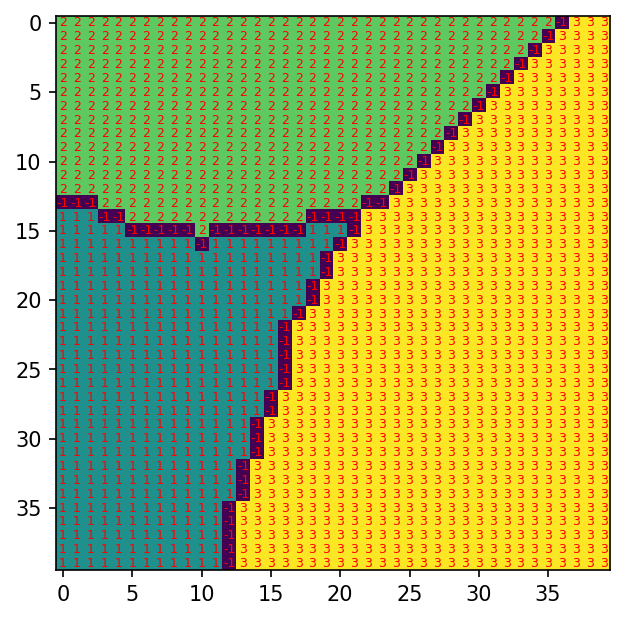

In [96]:
zoomed_in = labels[150:190, 230:270]

fig, ax = plt.subplots(dpi=150)
ax.imshow(zoomed_in)

for i in range(zoomed_in.shape[0]):
    for j in range(zoomed_in.shape[1]):
        ax.text(j, i, str(zoomed_in[i, j]), color='r', ha='center', va='center', size=6)

**Exercise 3.6**

Use watershed to detect the two rectangles below. Find the bounding boxes from the labels.

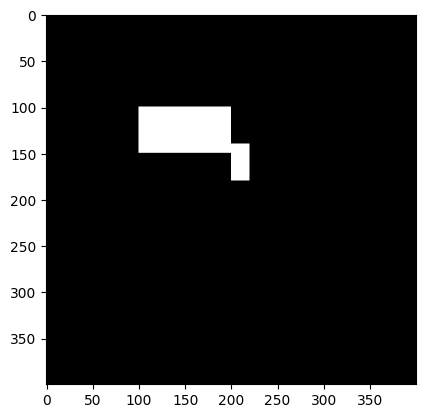

In [97]:
im_rectangles = np.zeros((400, 400), dtype="uint8")
im_rectangles[100:150, 100:200] = 255
im_rectangles[140:180, 200:220] = 255
plt.imshow(im_rectangles, cmap='gray')

In [98]:
# YOUR CODE HERE
kernel = np.ones((7, 7), dtype="uint8")
sure_bg = cv2.dilate(im_rectangles, kernel, iterations=3)
sure_fg = cv2.erode(im_rectangles, kernel, iterations=3) # make sure erosion separates the two
unknown = sure_bg - sure_fg

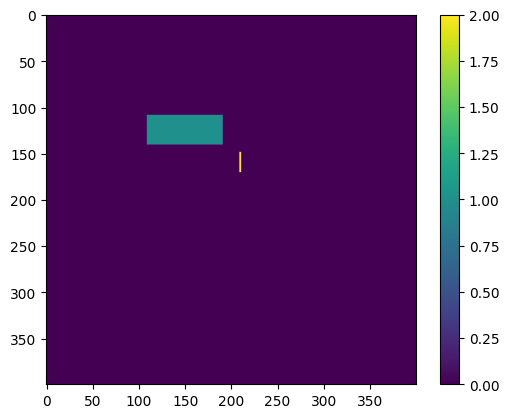

In [99]:
retval, labels, stats, centroids = cv2.connectedComponentsWithStats(sure_fg)
plt.imshow(labels)
plt.colorbar()

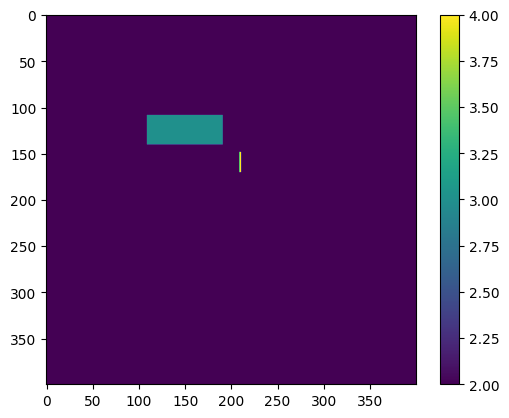

In [101]:
labels = labels + 1
plt.imshow(labels)
plt.colorbar()

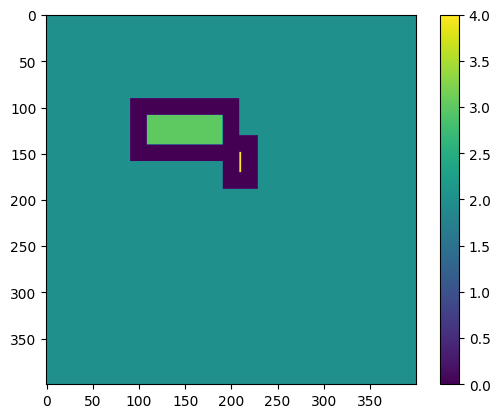

In [102]:
labels[unknown == 255] = 0
plt.imshow(labels)
plt.colorbar()

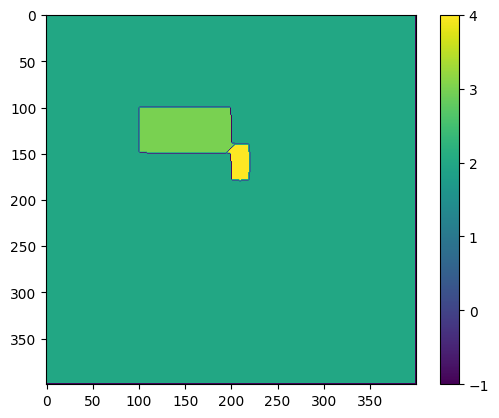

In [103]:
labels = cv2.watershed(np.stack((im_rectangles, im_rectangles, im_rectangles), axis=2), labels)
plt.imshow(labels)
plt.colorbar()

**Exercise 3.7**

Read the following example to see how watershed works with scikit-image.

https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_watershed.html